# CRYO2ICE Track Alignment Verification

## 1. Introduction

This notebook performs a verification analysis of the spatial alignment between CryoSat-2 (CS2) and ICESat-2 (IS2) satellite tracks that are identified as CRYO2ICE coincident tracks.

Tracks were initially identified using the www.cs2eo.org tool, and downloaded using their provided scripts. This verification is necessary because the cs2eo.org tool may identify more ICESat-2 tracks than CryoSat-2 tracks when the ICESat-2 orbit changes while crossing the polar regions. Therefore, manual verification is required to confirm whether the identified pairs are truly coincident CRYO2ICE tracks.

This analysis focuses on the austral winter 2021 observations over both the Weddell and Ross seas as a representative case study.

## 2. Data Loading

Load all available CS2 and IS2 data files for the Weddell Sea region during winter 2021. The CryoSat-2 data are Level-2 SAR Baseline-E products, while the ICESat-2 data are from the ATL10 sea ice freeboard product (version 6).

In [1]:
import glob

# Base directory
directory = r'D:\phd\data\chap2'

# CryoSat-2 Level-2 SAR Baseline-E datasets for Weddell Sea winter 2021
# Example filename: CS_LTA__SIR_SAR_2__20210501T004324_20210501T004940_E001_segment_640.nc
cs2_dir = directory + r'\cs2_l2_sar_basel_e_weddell_winter\2021'
files_check_CS2 = glob.glob(cs2_dir + r'\*.nc')
print(f"Number of CryoSat-2 files: {len(files_check_CS2)}")

# ICESat-2 ATL10 datasets for Weddell Sea winter 2021
# Example filename: ATL10-02_20210501044315_05711101_006_01.h5
is2_dir = directory + r'\is2_atl10v6_weddell_winter\2021'
files_check_IS2 = glob.glob(is2_dir + r'\*.h5')
print(f"Number of ICESat-2 files: {len(files_check_IS2)}")

Number of CryoSat-2 files: 1285
Number of ICESat-2 files: 1270


## 3. ICESat-2 Data Structure Inspection

### 3.1 Select and Examine an Example ICESat-2 Dataset

Before comparing tracks, we need to understand the structure of the ICESat-2 ATL10 data product. The following code explores one example file to identify how freeboard measurements and geographical coordinates are stored within the HDF5 structure. 

ICESat-2 uses six beams arranged in three pairs (strong and weak). Each pair is identified as gt1l/r, gt2l/r, and gt3l/r, where 'l' and 'r' denote the left and right beams respectively. For proper track alignment verification, we need to extract valid coordinate data from all six beams.

In [6]:
import h5py
import numpy as np
import os

# Define the file path
file_path = r'D:\phd\data\chap2\is2_atl10v6_weddell_winter\2021\ATL10-02_20210501044315_05711101_006_01.h5'

# Function to recursively explore HDF5 group structure
def explore_group(group, prefix=''):
    """Recursively explore an HDF5 group to find datasets related to freeboard"""
    freeboard_datasets = []
    
    for key in group.keys():
        item = group[key]
        path = f"{prefix}/{key}" if prefix else key
        
        # If item is a dataset, check if it might be freeboard-related
        if isinstance(item, h5py.Dataset):
            # Look for keywords related to freeboard in the name
            if any(keyword in key.lower() for keyword in ['freeboard', 'fb', 'height']):
                freeboard_datasets.append((path, item))
        # If item is a group, explore it recursively
        elif isinstance(item, h5py.Group):
            freeboard_datasets.extend(explore_group(item, path))
    
    return freeboard_datasets

# Check if file exists
if not os.path.exists(file_path):
    print(f"Error: File not found: {file_path}")
else:
    print(f"File found: {os.path.basename(file_path)}")
    
    # Open the file
    with h5py.File(file_path, 'r') as f:
        # Print the top-level groups
        print("\nTop-level groups in the file:")
        print("----------------------------")
        for key in f.keys():
            print(key)
        
        # Check specifically for the six beams
        print("\nDetailed beam inspection:")
        print("------------------------")
        expected_beams = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
        
        for beam in expected_beams:
            if beam in f:
                print(f"\n✓ {beam}: Found")
                
                # Explore the beam group to find freeboard-related datasets
                fb_datasets = explore_group(f[beam], beam)
                
                if fb_datasets:
                    print(f"  Freeboard-related datasets found:")
                    for path, dataset in fb_datasets:
                        # Get dataset shape and data type
                        shape_str = f"shape={dataset.shape}"
                        dtype_str = f"dtype={dataset.dtype}"
                        
                        print(f"  - {path} ({shape_str}, {dtype_str})")
                        
                        # If the dataset looks promising, print some statistics
                        if len(dataset.shape) > 0 and dataset.shape[0] > 0:
                            try:
                                data = np.array(dataset)
                                if np.issubdtype(data.dtype, np.number):
                                    valid_data = data[~np.isnan(data)] if hasattr(data, 'mask') else data
                                    if len(valid_data) > 0:
                                        print(f"    Values: min={np.nanmin(valid_data):.3f}, max={np.nanmax(valid_data):.3f}, mean={np.nanmean(valid_data):.3f}")
                                        print(f"    Valid values: {len(valid_data)} / {data.size}")
                            except Exception as e:
                                print(f"    Error analyzing data: {str(e)}")
                else:
                    print("  No freeboard-related datasets found")
                
                # Also look for lat/lon coordinates
                try:
                    lat_lon_paths = []
                    for path, dataset in explore_group(f[beam], beam):
                        if 'lat' in path.lower() or 'lon' in path.lower():
                            lat_lon_paths.append(path)
                    
                    if lat_lon_paths:
                        print("\n  Coordinate datasets:")
                        for path in lat_lon_paths[:5]:  # Limit to first 5 to avoid too much output
                            print(f"  - {path}")
                        
                        if len(lat_lon_paths) > 5:
                            print(f"    (and {len(lat_lon_paths) - 5} more)")
                except Exception as e:
                    print(f"  Error finding coordinates: {str(e)}")
            else:
                print(f"✗ {beam}: Not found")

        # Print overall assessment
        beam_count = sum(1 for beam in expected_beams if beam in f)
        print(f"\nSummary: Found {beam_count} out of {len(expected_beams)} expected beams")

File found: ATL10-02_20210501044315_05711101_006_01.h5

Top-level groups in the file:
----------------------------
ancillary_data
orbit_info
quality_assessment
METADATA
gt1l
gt1r
gt2l
gt2r
gt3l
gt3r

Detailed beam inspection:
------------------------

✓ gt1l: Found
  Freeboard-related datasets found:
  - gt1l/freeboard_segment/beam_fb_confidence (shape=(25064,), dtype=float32)
    Values: min=0.006, max=0.084, mean=0.024
    Valid values: 25064 / 25064
  - gt1l/freeboard_segment/beam_fb_height (shape=(25064,), dtype=float32)
    Values: min=0.000, max=340282346638528859811704183484516925440.000, mean=inf
    Valid values: 25064 / 25064
  - gt1l/freeboard_segment/beam_fb_quality_flag (shape=(25064,), dtype=int8)
    Values: min=1.000, max=4.000, mean=1.015
    Valid values: 25064 / 25064
  - gt1l/freeboard_segment/beam_fb_unc (shape=(25064,), dtype=float32)
    Values: min=0.004, max=340282346638528859811704183484516925440.000, mean=inf
    Valid values: 25064 / 25064
  - gt1l/freeboard

c:\Users\xliu38\OneDrive - University of Tasmania\PhD_manuscripts\manuscript2\scripts\.venv\lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


    Values: min=0.006, max=0.093, mean=0.025
    Valid values: 25238 / 25238
  - gt1r/freeboard_segment/beam_fb_height (shape=(25238,), dtype=float32)
    Values: min=0.000, max=340282346638528859811704183484516925440.000, mean=inf
    Valid values: 25238 / 25238
  - gt1r/freeboard_segment/beam_fb_quality_flag (shape=(25238,), dtype=int8)
    Values: min=1.000, max=4.000, mean=1.023
    Valid values: 25238 / 25238
  - gt1r/freeboard_segment/beam_fb_unc (shape=(25238,), dtype=float32)
    Values: min=0.003, max=340282346638528859811704183484516925440.000, mean=inf
    Valid values: 25238 / 25238
  - gt1r/freeboard_segment/height_segment_id (shape=(25238,), dtype=int32)
    Values: min=1.000, max=25987.000, mean=12726.591
    Valid values: 25238 / 25238
  - gt1r/freeboard_segment/geophysical/height_segment_dac (shape=(25238,), dtype=float32)
    Values: min=0.181, max=0.451, mean=0.203
    Valid values: 25238 / 25238
  - gt1r/freeboard_segment/geophysical/height_segment_dynib (shape=(252

## 4. Track Alignment Visualization

### 4.1 Visual Comparison of CryoSat-2 and ICESat-2 Tracks

To verify if the identified tracks are truly coincident CRYO2ICE pairs, we select five random examples and visualize their geographical footprints on polar stereographic maps. The visualization uses blue markers for CryoSat-2 data and orange 'x' markers for ICESat-2 data. 

Close alignment between the blue and orange tracks would indicate successful CRYO2ICE coincident observations, validating that these are indeed spatially coherent measurement pairs suitable for cross-satellite comparison studies.

The figure titles include timestamps extracted from the filenames to confirm temporal proximity of the measurements.


Processing example 1/5 (file index 228):
CS2 file: CS_LTA__SIR_SAR_2__20210602T113719_20210602T113727_E003_segment_439.nc
IS2 file: ATL10-02_20210602064513_10611101_006_01.h5
  CS2 data loaded: -- valid points
  Beam gt1l: 62114 valid points
  Beam gt1r: 105676 valid points
  Beam gt2l: 71318 valid points
  Beam gt2r: 96127 valid points
  Beam gt3l: 79891 valid points
  Beam gt3r: 101334 valid points
  Total IS2 data points: 516460

Processing example 2/5 (file index 51):
CS2 file: CS_LTA__SIR_SAR_2__20210507T234721_20210507T235407_E001_segment_691.nc
IS2 file: ATL10-02_20210508172635_06861101_006_01.h5
  CS2 data loaded: -- valid points
  Beam gt1l: 45350 valid points
  Beam gt1r: 50044 valid points
  Beam gt2l: 34117 valid points
  Beam gt2r: 44538 valid points
  Beam gt3l: 49439 valid points
  Beam gt3r: 58091 valid points
  Total IS2 data points: 281579

Processing example 3/5 (file index 563):
CS2 file: CS_LTA__SIR_SAR_2__20210720T174021_20210720T174406_E001_segment_348.nc
IS2 fi

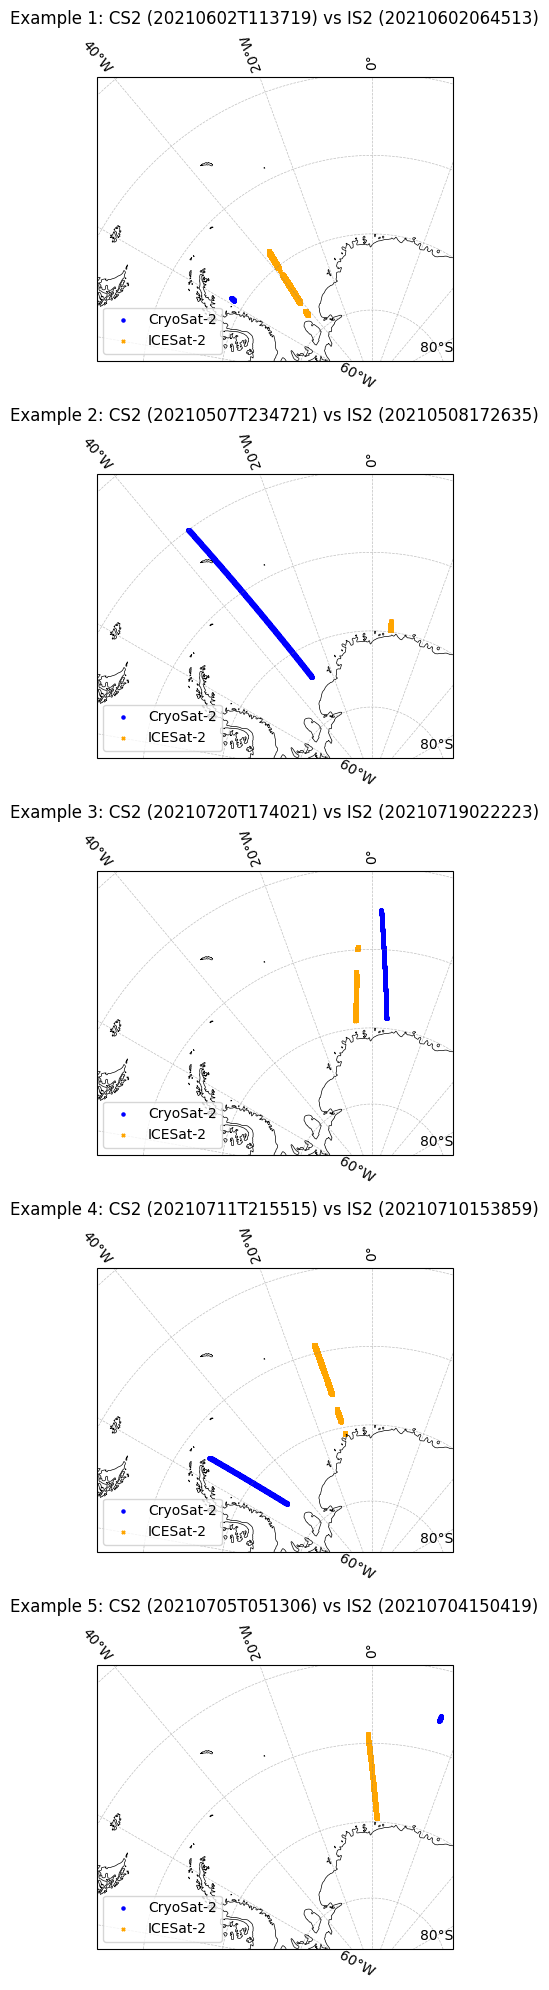

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import netCDF4
import random
import os
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set random seed for reproducibility
random.seed(42)

# Select 5 random indices (make sure we don't exceed the available files)
max_idx = min(len(files_check_CS2), len(files_check_IS2))
random_indices = random.sample(range(max_idx), min(5, max_idx))

# Create a figure with subplots for the 5 examples
fig = plt.figure(figsize=(15, 20))

for i, N in enumerate(random_indices):
    print(f"\nProcessing example {i+1}/{len(random_indices)} (file index {N}):")
    # Use os.path.basename() to avoid backslash issues in f-strings
    print(f"CS2 file: {os.path.basename(files_check_CS2[N])}")
    print(f"IS2 file: {os.path.basename(files_check_IS2[N])}")
    
    # Load CS2 data
    ds = netCDF4.Dataset(files_check_CS2[N], 'r')
    
    # Extract time information from CS2 filename
    cs2_filename = os.path.basename(files_check_CS2[N])
    cs2_time_str = cs2_filename.split('__')[2].split('_')[0]
    
    # Load CS2 data
    try:
        freeboard_CS2 = ds.variables['radar_freeboard_20_ku'][:]
        lat_CS2 = ds.variables['lat_poca_20_ku'][:]
        lon_CS2 = ds.variables['lon_poca_20_ku'][:]
        # Filter out invalid values
        valid_CS2 = ~np.isnan(freeboard_CS2) & (freeboard_CS2 != 0) & (freeboard_CS2 < 100)  # Filter unrealistic values
        lat_CS2 = lat_CS2[valid_CS2]
        lon_CS2 = lon_CS2[valid_CS2]
        print(f"  CS2 data loaded: {sum(valid_CS2)} valid points")
    except Exception as e:
        print(f"  Error loading CS2 data: {str(e)}")
        lon_CS2 = np.array([])
        lat_CS2 = np.array([])
    finally:
        ds.close()
    
    # Load IS2 data
    file = h5py.File(files_check_IS2[N], 'r')
    
    # Extract time information from IS2 filename
    is2_filename = os.path.basename(files_check_IS2[N])
    is2_time_str = is2_filename.split('_')[1]
    
    # Process all beams
    all_beams = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
    lon_all = []
    lat_all = []
    
    for beam in all_beams:
        try:
            # Correct paths based on the inspection output
            # First try to find latitude and longitude directly in the freeboard_segment
            try:
                lon = np.array(file[f"{beam}/freeboard_segment/longitude"])
                lat = np.array(file[f"{beam}/freeboard_segment/latitude"])
            except:
                # If not found directly, check if they're in the heights subgroup
                try:
                    lon = np.array(file[f"{beam}/freeboard_segment/heights/longitude"])
                    lat = np.array(file[f"{beam}/freeboard_segment/heights/latitude"])
                except:
                    # As a fallback, search through the entire beam structure for lat/lon
                    for group_name in file[beam]:
                        if "longitude" in file[f"{beam}/{group_name}"]:
                            lon = np.array(file[f"{beam}/{group_name}/longitude"])
                            lat = np.array(file[f"{beam}/{group_name}/latitude"])
                            break
            
            # Try to get freeboard heights (just for filtering valid points)
            try:
                freeboard = np.array(file[f"{beam}/freeboard_segment/beam_fb_height"])
                valid_idx = ~np.isnan(freeboard) & ~np.isinf(freeboard) & (freeboard < 10) & (freeboard >= 0)
            except:
                try:
                    freeboard = np.array(file[f"{beam}/freeboard_segment/heights/height_segment_height"])
                    valid_idx = ~np.isnan(freeboard) & ~np.isinf(freeboard) & (freeboard < 10) & (freeboard > -10)
                except:
                    # If can't find freeboard data, use all points
                    valid_idx = np.ones(len(lon), dtype=bool)
            
            if sum(valid_idx) > 0:
                lon_all.append(lon[valid_idx])
                lat_all.append(lat[valid_idx])
                print(f"  Beam {beam}: {sum(valid_idx)} valid points")
                
        except Exception as e:
            print(f"  Warning: Error processing beam {beam}: {str(e)}")
    
    file.close()
    
    # Create combined arrays
    if lon_all:
        lon_IS2 = np.hstack(lon_all)
        lat_IS2 = np.hstack(lat_all)
        print(f"  Total IS2 data points: {len(lon_IS2)}")
    else:
        print("  Warning: No valid IS2 data found")
        lon_IS2 = np.array([])
        lat_IS2 = np.array([])
    
    # Create subplot with a map projection
    ax = plt.subplot(5, 1, i+1, projection=ccrs.SouthPolarStereo(true_scale_latitude=-71))
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    
    # Plot CS2 track if available - using blue color
    if len(lon_CS2) > 0:
        ax.scatter(lon_CS2, lat_CS2, s=5, color='blue', 
                  transform=ccrs.PlateCarree(), label='CryoSat-2')
    
    # Plot IS2 tracks if available - using orange color and 'x' marker
    if len(lon_IS2) > 0:
        ax.scatter(lon_IS2, lat_IS2, s=5, color='orange', 
                  transform=ccrs.PlateCarree(), label='ICESat-2', 
                  marker='x')
    
    # Set extent to show Weddell Sea region
    ax.set_extent([-62, 15, -83, -50], crs=ccrs.PlateCarree())
    
    # Add title
    ax.set_title(f"Example {i+1}: CS2 ({cs2_time_str}) vs IS2 ({is2_time_str})")
    ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

## 5. Ross Sea Region Analysis

### 5.1 Ross Sea Data Loading

To complement our analysis of the Weddell Sea region, we now examine the Ross Sea sector. For the Ross Sea region, the CryoSat-2 data is divided into two parts based on hemispheric longitude ranges:

1. Eastern Hemisphere (EH): 160°E-180°E, 78°S-50°S
2. Western Hemisphere (WH): 180°-140°W, 78°S-50°S

This division helps manage the data across the 180° meridian boundary. We'll load and combine data from both hemispheric regions for a comprehensive analysis of the Ross Sea sector.

In [1]:
import glob

# Base directory
directory = r'D:\phd\data\chap2'

# CryoSat-2 Level-2 SAR Baseline-E datasets for Ross Sea winter 2021
# The data is split into Eastern Hemisphere (160°E-180°E) and Western Hemisphere (180°-140°W) parts
cs2_dir_eh = directory + r'\cs2_l2_sar_basel_e_ross_winter\EH\2021'
cs2_dir_wh = directory + r'\cs2_l2_sar_basel_e_ross_winter\WH\2021'

# Load files from both hemispheres
files_check_CS2_eh = glob.glob(cs2_dir_eh + r'\*.nc')
files_check_CS2_wh = glob.glob(cs2_dir_wh + r'\*.nc')

# Combine the file lists
files_check_CS2 = files_check_CS2_eh + files_check_CS2_wh
print(f"Number of CryoSat-2 files: {len(files_check_CS2)} (EH: {len(files_check_CS2_eh)}, WH: {len(files_check_CS2_wh)})")

# ICESat-2 ATL10 datasets for Ross Sea winter 2021
# Example filename: ATL10-02_20210501044315_05711101_006_01.h5
is2_dir = directory + r'\is2_atl10v6_ross_winter\2021'
files_check_IS2 = glob.glob(is2_dir + r'\*.h5')
print(f"Number of ICESat-2 files: {len(files_check_IS2)}")

Number of CryoSat-2 files: 1022 (EH: 364, WH: 658)
Number of ICESat-2 files: 972


### 5.2 Ross Sea Track Alignment Visualisation

Similar to our Weddell Sea analysis, we now visualise the spatial alignment between CryoSat-2 and ICESat-2 tracks in the Ross Sea region. This visualisation is crucial because the Ross Sea's location around the 180° meridian presents additional challenges for track alignment verification.

The map uses a South Polar Stereographic projection centered on the Ross Sea sector. Blue markers represent CryoSat-2 data points, while orange 'x' markers show ICESat-2 measurements. Close alignment between the markers would confirm successful coincident observations in this challenging region.

Note: The Ross Sea region spans the International Date Line, requiring data from both Eastern (160°E-180°E) and Western (180°-140°W) Hemisphere sections to be combined for proper analysis.


Processing example 1/5 (file index 654):
CS2 file: CS_LTA__SIR_SAR_2__20210721T051257_20210721T051649_E001_segment_188.nc
IS2 file: ATL10-02_20210901115052_10671201_006_02.h5
  CS2 data loaded: -- valid points
  Beam gt1l: 62546 valid points
  Beam gt1r: 63973 valid points
  Beam gt2l: 51404 valid points
  Beam gt2r: 54542 valid points
  Beam gt3l: 51270 valid points
  Beam gt3r: 65844 valid points
  Total IS2 data points: 349579
  CS2 points in Ross Sea region: 5027 out of 5027
  IS2 points in Ross Sea region: 306264 out of 349579

Processing example 2/5 (file index 114):
CS2 file: CS_LTA__SIR_SAR_2__20210627T183842_20210627T184152_E003_segment_177.nc
IS2 file: ATL10-02_20210522064433_08931101_006_01.h5
  CS2 data loaded: -- valid points
  Beam gt1l: 74542 valid points
  Beam gt1r: 73829 valid points
  Beam gt2l: 61652 valid points
  Beam gt2r: 66091 valid points
  Beam gt3l: 72267 valid points
  Beam gt3r: 79528 valid points
  Total IS2 data points: 427909
  CS2 points in Ross Sea r

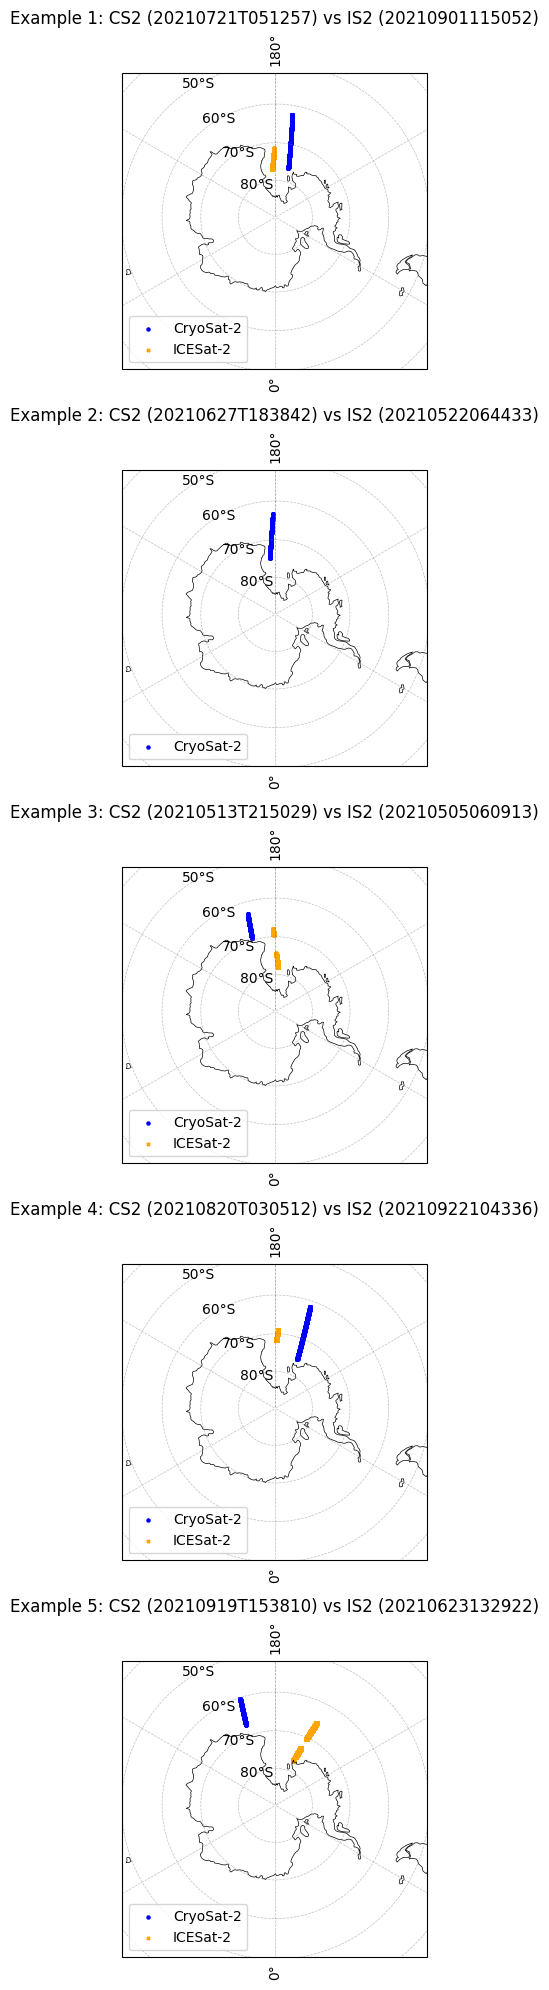

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import netCDF4
import random
import os
import re
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set random seed for reproducibility
random.seed(42)

# Select 5 random indices (make sure we don't exceed the available files)
max_idx = min(len(files_check_CS2), len(files_check_IS2))
random_indices = random.sample(range(max_idx), min(5, max_idx))

# Create a figure with subplots for the 5 examples
fig = plt.figure(figsize=(15, 20))

for i, N in enumerate(random_indices):
    print(f"\nProcessing example {i+1}/{len(random_indices)} (file index {N}):")
    # Use os.path.basename() to avoid backslash issues in f-strings
    print(f"CS2 file: {os.path.basename(files_check_CS2[N])}")
    print(f"IS2 file: {os.path.basename(files_check_IS2[N])}")
    
    # Load CS2 data
    ds = netCDF4.Dataset(files_check_CS2[N], 'r')
    
    # Extract time information from CS2 filename - FIXED to handle different filename formats
    cs2_filename = os.path.basename(files_check_CS2[N])
    try:
        # First try the original format
        cs2_time_str = cs2_filename.split('__')[2].split('_')[0]
    except IndexError:
        # If that fails, try to extract date pattern (YYYYMMDDTHHMMSS)
        match = re.search(r'(\d{8}T\d{6})', cs2_filename)
        if match:
            cs2_time_str = match.group(1)
        else:
            # Fallback: just use the filename without extension
            cs2_time_str = cs2_filename.split('.')[0]
    
    # Load CS2 data
    try:
        freeboard_CS2 = ds.variables['radar_freeboard_20_ku'][:]
        lat_CS2 = ds.variables['lat_poca_20_ku'][:]
        lon_CS2 = ds.variables['lon_poca_20_ku'][:]
        # Filter out invalid values
        valid_CS2 = ~np.isnan(freeboard_CS2) & (freeboard_CS2 != 0) & (freeboard_CS2 < 100)  # Filter unrealistic values
        lat_CS2 = lat_CS2[valid_CS2]
        lon_CS2 = lon_CS2[valid_CS2]
        print(f"  CS2 data loaded: {sum(valid_CS2)} valid points")
    except Exception as e:
        print(f"  Error loading CS2 data: {str(e)}")
        lon_CS2 = np.array([])
        lat_CS2 = np.array([])
    finally:
        ds.close()
    
    # Load IS2 data
    file = h5py.File(files_check_IS2[N], 'r')
    
    # Extract time information from IS2 filename
    is2_filename = os.path.basename(files_check_IS2[N])
    is2_time_str = is2_filename.split('_')[1]
    
    # Process all beams
    all_beams = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
    lon_all = []
    lat_all = []
    
    for beam in all_beams:
        try:
            # Correct paths based on the inspection output
            # First try to find latitude and longitude directly in the freeboard_segment
            try:
                lon = np.array(file[f"{beam}/freeboard_segment/longitude"])
                lat = np.array(file[f"{beam}/freeboard_segment/latitude"])
            except:
                # If not found directly, check if they're in the heights subgroup
                try:
                    lon = np.array(file[f"{beam}/freeboard_segment/heights/longitude"])
                    lat = np.array(file[f"{beam}/freeboard_segment/heights/latitude"])
                except:
                    # As a fallback, search through the entire beam structure for lat/lon
                    for group_name in file[beam]:
                        if "longitude" in file[f"{beam}/{group_name}"]:
                            lon = np.array(file[f"{beam}/{group_name}/longitude"])
                            lat = np.array(file[f"{beam}/{group_name}/latitude"])
                            break
            
            # Try to get freeboard heights (just for filtering valid points)
            try:
                freeboard = np.array(file[f"{beam}/freeboard_segment/beam_fb_height"])
                valid_idx = ~np.isnan(freeboard) & ~np.isinf(freeboard) & (freeboard < 10) & (freeboard >= 0)
            except:
                try:
                    freeboard = np.array(file[f"{beam}/freeboard_segment/heights/height_segment_height"])
                    valid_idx = ~np.isnan(freeboard) & ~np.isinf(freeboard) & (freeboard < 10) & (freeboard > -10)
                except:
                    # If can't find freeboard data, use all points
                    valid_idx = np.ones(len(lon), dtype=bool)
            
            if sum(valid_idx) > 0:
                lon_all.append(lon[valid_idx])
                lat_all.append(lat[valid_idx])
                print(f"  Beam {beam}: {sum(valid_idx)} valid points")
                
        except Exception as e:
            print(f"  Warning: Error processing beam {beam}: {str(e)}")
    
    file.close()
    
    # Create combined arrays
    if lon_all:
        lon_IS2 = np.hstack(lon_all)
        lat_IS2 = np.hstack(lat_all)
        print(f"  Total IS2 data points: {len(lon_IS2)}")
    else:
        print("  Warning: No valid IS2 data found")
        lon_IS2 = np.array([])
        lat_IS2 = np.array([])
    
    # Function to filter data points to Ross Sea region (160°E to 140°W, 78°S to 50°S)
    def in_ross_sea(lon, lat):
        # Convert longitude to -180 to 180 range
        lon_norm = ((lon + 180) % 360) - 180
        
        # Check if within the Ross Sea region
        # 160°E = 160, 140°W = -140 in the -180 to 180 range
        return ((lon_norm >= 160) or (lon_norm <= -140)) and (lat >= -78) and (lat <= -50)
    
    # Filter CS2 data to Ross Sea region
    if len(lon_CS2) > 0:
        ross_sea_mask = np.array([in_ross_sea(lon, lat) for lon, lat in zip(lon_CS2, lat_CS2)])
        lon_CS2_filtered = lon_CS2[ross_sea_mask]
        lat_CS2_filtered = lat_CS2[ross_sea_mask]
        print(f"  CS2 points in Ross Sea region: {sum(ross_sea_mask)} out of {len(ross_sea_mask)}")
    else:
        lon_CS2_filtered = np.array([])
        lat_CS2_filtered = np.array([])
    
    # Filter IS2 data to Ross Sea region
    if len(lon_IS2) > 0:
        ross_sea_mask = np.array([in_ross_sea(lon, lat) for lon, lat in zip(lon_IS2, lat_IS2)])
        lon_IS2_filtered = lon_IS2[ross_sea_mask]
        lat_IS2_filtered = lat_IS2[ross_sea_mask]
        print(f"  IS2 points in Ross Sea region: {sum(ross_sea_mask)} out of {len(ross_sea_mask)}")
    else:
        lon_IS2_filtered = np.array([])
        lat_IS2_filtered = np.array([])
    
    # Create subplot with a map projection
    ax = plt.subplot(5, 1, i+1, projection=ccrs.SouthPolarStereo(central_longitude=180, true_scale_latitude=-71))
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    
    # Plot CS2 track if available - using blue color
    if len(lon_CS2_filtered) > 0:
        ax.scatter(lon_CS2_filtered, lat_CS2_filtered, s=5, color='blue', 
                  transform=ccrs.PlateCarree(), label='CryoSat-2')
    
    # Plot IS2 tracks if available - using orange color and 'x' marker
    if len(lon_IS2_filtered) > 0:
        ax.scatter(lon_IS2_filtered, lat_IS2_filtered, s=5, color='orange', 
                  transform=ccrs.PlateCarree(), label='ICESat-2', 
                  marker='x')
    
    # Set extent to show Ross Sea region
    # Use central_longitude=180 to properly handle the date line
    ross_sea_extent = [-140, 160, -78, -50]  # [West, East, South, North] in Plate Carree
    ax.set_extent(ross_sea_extent, crs=ccrs.PlateCarree())
    
    # Add title
    ax.set_title(f"Example {i+1}: CS2 ({cs2_time_str}) vs IS2 ({is2_time_str})")
    ax.legend(loc='lower left')

plt.tight_layout()
plt.show()